In [104]:
import numpy as np
import pandas as pd


df = pd.read_csv("/content/USA_Housing.csv")

X = df.drop("Price", axis=1).values
y = df["Price"].values.reshape(-1, 1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)





Shape of X: (5000, 5)
Shape of y: (5000, 1)


In [105]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = np.c_[np.ones(X.shape[0]), X]



In [106]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [107]:
def least_squares_beta(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y


def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

betas, scores = [], []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    beta = least_squares_beta(X_train, y_train)
    y_pred = X_test @ beta
    score = r2_score(y_test, y_pred)

    betas.append(beta)
    scores.append(score)

print("R² scores for 5 folds:", scores)


R² scores for 5 folds: [np.float64(0.9179971706985147), np.float64(0.9145677884802818), np.float64(0.9116116385364478), np.float64(0.9193091764960816), np.float64(0.9243869413350316)]


In [108]:
from sklearn.model_selection import train_test_split

best_idx = np.argmax(scores)
best_beta = betas[best_idx]
print("Best Fold =", best_idx+1, "with R² =", scores[best_idx])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_pred_final = X_test @ best_beta
final_r2 = r2_score(y_test, y_pred_final)

print("Final R² Score on 70-30 split:", final_r2)


Best Fold = 5 with R² = 0.9243869413350316
Final R² Score on 70-30 split: 0.9147458156636434


In [109]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("USA_Housing.csv")
X = df.drop("Price", axis=1).values
y = df["Price"].values.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.c_[np.ones(X.shape[0]), X]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)

def gradient_descent(X, y, lr=0.01, iterations=1000):
    m, n = X.shape
    beta = np.zeros((n,1))
    for i in range(iterations):
        gradient = (1/m) * X.T @ (X @ beta - y)
        beta = beta - lr * gradient
    return beta

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot

learning_rates = [0.001, 0.01, 0.1, 1]
results = []

for lr in learning_rates:
    beta = gradient_descent(X_train, y_train, lr=lr, iterations=1000)
    y_val_pred = X_val @ beta
    y_test_pred = X_test @ beta
    r2_val = r2_score(y_val, y_val_pred)
    r2_test = r2_score(y_test, y_test_pred)
    results.append((lr, beta, r2_val, r2_test))

best = max(results, key=lambda x: x[2])
best_lr, best_beta, best_val_r2, best_test_r2 = best

print("Best Learning Rate:", best_lr)
print("Validation R²:", best_val_r2)
print("Test R²:", best_test_r2)


Best Learning Rate: 0.01
Validation R²: 0.9098183094422969
Test R²: 0.9147434800538763


QUESTION 3

Step 1: Loading the dataset...
Dataset loaded successfully. Shape: (205, 26)
First few rows:
   symboling  normalized_losses         make fuel_type aspiration num_doors  \
0          3                NaN  alfa-romero       gas        std       two   
1          3                NaN  alfa-romero       gas        std       two   
2          1                NaN  alfa-romero       gas        std       two   
3          2              164.0         audi       gas        std      four   
4          2              164.0         audi       gas        std      four   

    body_style drive_wheels engine_location  wheel_base  ...  engine_size  \
0  convertible          rwd           front        88.6  ...          130   
1  convertible          rwd           front        88.6  ...          130   
2    hatchback          rwd           front        94.5  ...          152   
3        sedan          fwd           front        99.8  ...          109   
4        sedan          4wd           front    

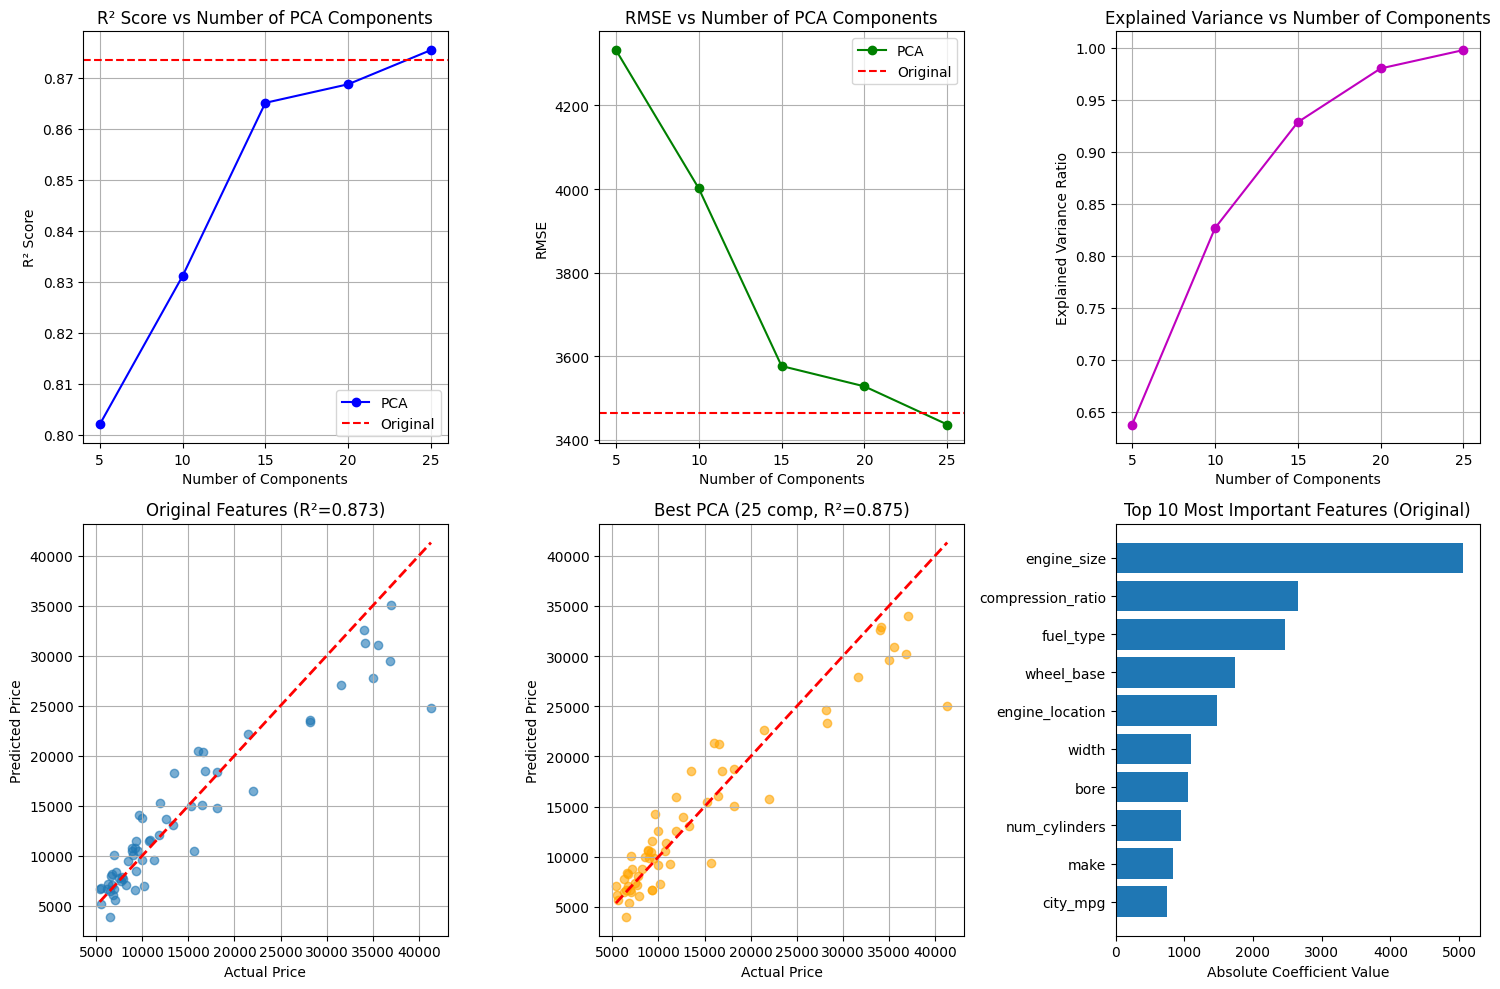


DATASET SUMMARY
Total samples: 201
Total features after preprocessing: 31
Price range: $5118 - $45400
Average price: $13207

Feature categories:
- Original numeric features: 15
- Label encoded features: 4
- Binary encoded features: 2
- Dummy encoded features: 8
- Word-to-number converted: 2


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("Step 1: Loading the dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"


column_names = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration",
                "num_doors", "body_style", "drive_wheels", "engine_location",
                "wheel_base", "length", "width", "height", "curb_weight",
                "engine_type", "num_cylinders", "engine_size", "fuel_system",
                "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm",
                "city_mpg", "highway_mpg", "price"]
try:

    df = pd.read_csv(url, names=column_names, na_values=['?'])
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    print(f"First few rows:\n{df.head()}")
    print(f"Data types:\n{df.dtypes}")
    print(f"Missing values before preprocessing:\n{df.isnull().sum()}")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Creating sample data for demonstration...")
    np.random.seed(42)
    n_samples = 200
    df = pd.DataFrame({
        'symboling': np.random.randint(-2, 4, n_samples),
        'normalized_losses': np.random.normal(150, 50, n_samples),
        'make': np.random.choice(['toyota', 'honda', 'bmw', 'audi', 'mercedes'], n_samples),
        'fuel_type': np.random.choice(['gas', 'diesel'], n_samples),
        'aspiration': np.random.choice(['std', 'turbo'], n_samples),
        'num_doors': np.random.choice(['two', 'four'], n_samples),
        'body_style': np.random.choice(['sedan', 'hatchback', 'wagon', 'hardtop'], n_samples),
        'drive_wheels': np.random.choice(['rwd', 'fwd', '4wd'], n_samples),
        'engine_location': np.random.choice(['front', 'rear'], n_samples),
        'wheel_base': np.random.normal(100, 10, n_samples),
        'length': np.random.normal(170, 15, n_samples),
        'width': np.random.normal(65, 5, n_samples),
        'height': np.random.normal(55, 3, n_samples),
        'curb_weight': np.random.normal(2500, 500, n_samples),
        'engine_type': np.random.choice(['ohc', 'ohcv', 'l', 'rotor'], n_samples),
        'num_cylinders': np.random.choice(['four', 'six', 'eight'], n_samples),
        'engine_size': np.random.normal(120, 30, n_samples),
        'fuel_system': np.random.choice(['mpfi', 'pfi', '2bbl', '4bbl'], n_samples),
        'bore': np.random.normal(3.3, 0.3, n_samples),
        'stroke': np.random.normal(3.4, 0.4, n_samples),
        'compression_ratio': np.random.normal(9.5, 1.5, n_samples),
        'horsepower': np.random.normal(120, 40, n_samples),
        'peak_rpm': np.random.normal(5200, 800, n_samples),
        'city_mpg': np.random.normal(25, 5, n_samples),
        'highway_mpg': np.random.normal(30, 6, n_samples),
        'price': np.random.normal(15000, 8000, n_samples)
    })

    for col in ['normalized_losses', 'bore', 'stroke', 'horsepower', 'peak_rpm']:
        mask = np.random.random(n_samples) < 0.1
        df.loc[mask, col] = np.nan
    print(f"Sample dataset created. Shape: {df.shape}")


if 'price' in df.columns:
    df = df[df['price'] > 0].copy()
    print(f"After removing non-positive prices: {df.shape}")

if len(df) == 0:
    raise ValueError("No valid data remains after preprocessing!")

print("\nStep 2: Handling missing values...")


initial_shape = df.shape
df = df.dropna(subset=['price']).copy()
print(f"After dropping rows with missing price: {df.shape} (removed {initial_shape[0] - df.shape[0]} rows)")

if len(df) == 0:
    raise ValueError("No samples remain after dropping missing price values!")

# Replace NaN values with central tendency imputation
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric columns: {numeric_columns}")
print(f"Categorical columns: {categorical_columns}")

# For numeric columns, use median
for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled {col} with median: {median_val:.2f}")

for col in categorical_columns:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'unknown'
        df[col] = df[col].fillna(mode_val)
        print(f"Filled {col} with mode: {mode_val}")

print(f"Missing values after imputation: {df.isnull().sum().sum()}")
print(f"Current dataset shape: {df.shape}")

# Step 3: Convert non-numeric values to numeric
print("\nStep 3: Converting non-numeric values to numeric...")

if len(df) == 0:
    raise ValueError("No data available for feature encoding!")


def word_to_number(word):
    if pd.isna(word):
        return word
    word_dict = {'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6,
                 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12}
    if isinstance(word, str):
        return word_dict.get(word.lower(), word)
    return word

if 'num_doors' in df.columns:
    df['num_doors'] = df['num_doors'].apply(word_to_number)
    df['num_doors'] = pd.to_numeric(df['num_doors'], errors='coerce')
    print("Converted num_doors from words to numbers")

if 'num_cylinders' in df.columns:
    df['num_cylinders'] = df['num_cylinders'].apply(word_to_number)
    df['num_cylinders'] = pd.to_numeric(df['num_cylinders'], errors='coerce')
    print("Converted num_cylinders from words to numbers")

df = df.fillna(df.median(numeric_only=True))

if 'body_style' in df.columns:
    body_style_dummies = pd.get_dummies(df['body_style'], prefix='body_style')
    df = pd.concat([df, body_style_dummies], axis=1)
    df = df.drop(['body_style'], axis=1)
    print("Applied dummy encoding for body_style")

if 'drive_wheels' in df.columns:
    drive_wheels_dummies = pd.get_dummies(df['drive_wheels'], prefix='drive_wheels')
    df = pd.concat([df, drive_wheels_dummies], axis=1)
    df = df.drop(['drive_wheels'], axis=1)
    print("Applied dummy encoding for drive_wheels")

label_encoder = LabelEncoder()
for col in ['make', 'aspiration', 'engine_location', 'fuel_type']:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
        print(f"Applied label encoding for {col}")

if 'fuel_system' in df.columns:
    df['fuel_system'] = df['fuel_system'].apply(lambda x: 1 if 'pfi' in str(x).lower() else 0)
    print("Converted fuel_system: pfi=1, others=0")

if 'engine_type' in df.columns:
    df['engine_type'] = df['engine_type'].apply(lambda x: 1 if 'ohc' in str(x).lower() else 0)
    print("Converted engine_type: ohc=1, others=0")

print(f"Final dataset shape: {df.shape}")
print(f"Data types after conversion:\n{df.dtypes}")


non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print(f"Warning: Non-numeric columns remain: {non_numeric_cols}")
    # Convert remaining non-numeric columns
    for col in non_numeric_cols:
        if col != 'price':  # Don't convert price column
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.fillna(0)

print(f"All columns numeric check: {df.select_dtypes(include=[np.number]).shape[1] == df.shape[1]}")


print("\nStep 4: Preparing features and target variable...")

if len(df) == 0:
    raise ValueError("No data available after preprocessing!")


if 'price' not in df.columns:
    raise ValueError("Price column is missing from the dataset!")


X = df.drop('price', axis=1)
y = df['price']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

if X.shape[0] == 0:
    raise ValueError("No samples available for training!")

if X.shape[1] == 0:
    raise ValueError("No features available for training!")

print(f"Feature data types:\n{X.dtypes}")


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Features scaled using StandardScaler")
print(f"Scaled features shape: {X_scaled.shape}")
print(f"Sample of scaled features:\n{X_scaled.head()}")


print("\nStep 5: Training Linear Regression on original features...")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

lr_original = LinearRegression()
lr_original.fit(X_train, y_train)

y_pred_original = lr_original.predict(X_test)

mse_original = mean_squared_error(y_test, y_pred_original)
rmse_original = np.sqrt(mse_original)
mae_original = mean_absolute_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

print(f"Original Features - Linear Regression Performance:")
print(f"RMSE: {rmse_original:.2f}")
print(f"MAE: {mae_original:.2f}")
print(f"R² Score: {r2_original:.4f}")

print("\nStep 6: Applying PCA and training Linear Regression...")

pca_results = {}
n_components_list = [5, 10, 15, 20, min(25, X_scaled.shape[1]-1)]

best_r2 = -np.inf
best_n_components = None
best_results = None

for n_comp in n_components_list:
    if n_comp >= X_scaled.shape[1]:
        continue


    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_scaled)


    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
        X_pca, y, test_size=0.3, random_state=42
    )

    lr_pca = LinearRegression()
    lr_pca.fit(X_train_pca, y_train_pca)

    y_pred_pca = lr_pca.predict(X_test_pca)

    mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
    rmse_pca = np.sqrt(mse_pca)
    mae_pca = mean_absolute_error(y_test_pca, y_pred_pca)
    r2_pca = r2_score(y_test_pca, y_pred_pca)

    pca_results[n_comp] = {
        'rmse': rmse_pca,
        'mae': mae_pca,
        'r2': r2_pca,
        'explained_variance': pca.explained_variance_ratio_.sum()
    }

    if r2_pca > best_r2:
        best_r2 = r2_pca
        best_n_components = n_comp
        best_results = pca_results[n_comp]

    print(f"PCA with {n_comp} components:")
    print(f"  RMSE: {rmse_pca:.2f}")
    print(f"  MAE: {mae_pca:.2f}")
    print(f"  R² Score: {r2_pca:.4f}")
    print(f"  Explained Variance: {pca.explained_variance_ratio_.sum():.4f}")

# Performance comparison
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Original Features (All {X_scaled.shape[1]} features):")
print(f"  RMSE: {rmse_original:.2f}")
print(f"  MAE: {mae_original:.2f}")
print(f"  R² Score: {r2_original:.4f}")

print(f"\nBest PCA Results ({best_n_components} components):")
print(f"  RMSE: {best_results['rmse']:.2f}")
print(f"  MAE: {best_results['mae']:.2f}")
print(f"  R² Score: {best_results['r2']:.4f}")
print(f"  Explained Variance: {best_results['explained_variance']:.4f}")

# Performance improvement analysis
rmse_improvement = ((rmse_original - best_results['rmse']) / rmse_original) * 100
r2_improvement = ((best_results['r2'] - r2_original) / r2_original) * 100

print(f"\nPerformance Improvement:")
print(f"  RMSE Improvement: {rmse_improvement:.2f}%")
print(f"  R² Improvement: {r2_improvement:.2f}%")

if best_results['r2'] > r2_original:
    print("PCA led to performance improvement!")
else:
    print("PCA did not lead to performance improvement.")
    print("This could be due to loss of important information during dimensionality reduction.")


plt.figure(figsize=(15, 10))


plt.subplot(2, 3, 1)
components = list(pca_results.keys())
r2_scores = [pca_results[comp]['r2'] for comp in components]
plt.plot(components, r2_scores, 'bo-', label='PCA')
plt.axhline(y=r2_original, color='r', linestyle='--', label='Original')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.title('R² Score vs Number of PCA Components')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
rmse_scores = [pca_results[comp]['rmse'] for comp in components]
plt.plot(components, rmse_scores, 'go-', label='PCA')
plt.axhline(y=rmse_original, color='r', linestyle='--', label='Original')
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of PCA Components')
plt.legend()
plt.grid(True)

# Plot 3: Explained variance
plt.subplot(2, 3, 3)
explained_var = [pca_results[comp]['explained_variance'] for comp in components]
plt.plot(components, explained_var, 'mo-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)

# Plot 4: Actual vs Predicted (Original)
plt.subplot(2, 3, 4)
plt.scatter(y_test, y_pred_original, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Original Features (R²={r2_original:.3f})')
plt.grid(True)

# Plot 5: Actual vs Predicted (Best PCA)
plt.subplot(2, 3, 5)
# We need to recreate the best PCA model for plotting
pca_best = PCA(n_components=best_n_components)
X_pca_best = pca_best.fit_transform(X_scaled)
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
    X_pca_best, y, test_size=0.3, random_state=42
)
lr_best = LinearRegression()
lr_best.fit(X_train_best, y_train_best)
y_pred_best = lr_best.predict(X_test_best)

plt.scatter(y_test_best, y_pred_best, alpha=0.6, color='orange')
plt.plot([y_test_best.min(), y_test_best.max()], [y_test_best.min(), y_test_best.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Best PCA ({best_n_components} comp, R²={best_results["r2"]:.3f})')
plt.grid(True)

# Plot 6: Feature importance (coefficients) for original model
plt.subplot(2, 3, 6)
feature_importance = abs(lr_original.coef_)
top_features_idx = np.argsort(feature_importance)[-10:]  # Top 10 features
top_features = X.columns[top_features_idx]
top_importance = feature_importance[top_features_idx]

plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Most Important Features (Original)')
plt.tight_layout()

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total samples: {len(df)}")
print(f"Total features after preprocessing: {X_scaled.shape[1]}")
print(f"Price range: ${y.min():.0f} - ${y.max():.0f}")
print(f"Average price: ${y.mean():.0f}")

print(f"\nFeature categories:")
print(f"- Original numeric features: {len(numeric_columns)-1}")  # -1 for price
print(f"- Label encoded features: 4")
print(f"- Binary encoded features: 2")
print(f"- Dummy encoded features: {len(body_style_dummies.columns) + len(drive_wheels_dummies.columns)}")
print(f"- Word-to-number converted: 2")